# Project 3: Understanding User Behavior

In [1]:
import pyspark
import json
from pyspark.sql.functions import udf, from_json, mean as _mean, stddev as _stddev, col
from pyspark.sql.types import StructType, StructField, StringType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
spark

## Stream Incoming Events
Stream two main types of events and write them out to two separate directories in parquet format:  
1. `purchase events`: buy / sell items
2. `guild events`: join / leave guild
  
This requires two separately defined schemas to handle the different event types read from kafka and a branching spark stream to write these events in separate directories.  

This streaming process in the notebook is started before the python script `create_test_events.py` is executed and writes to the `event` kafka topic. The process is interrupted in order to stop once the event generating script completes.

In [3]:
def purchase_event_schema():
    """
    root
    |-- Accept: string (nullable = true)
    |-- Host: string (nullable = true)
    |-- User-Agent: string (nullable = true)
    |-- username: string (nullable = true)
    |-- event_type: string (nullable = true)
    |-- transaction_type: string (nullable = true)
    |-- item_category: string (nullable = true)
    |-- item_name: string (nullable = true)
    |-- timestamp: string (nullable = true)
    """
    return StructType([
        StructField("Accept", StringType(), True),
        StructField("Host", StringType(), True),
        StructField("User-Agent", StringType(), True),
        StructField("username", StringType(), True),
        StructField("event_type", StringType(), True),
        StructField("transaction_type", StringType(), True),
        StructField("item_category", StringType(), True),
        StructField("item_name", StringType(), True),
        StructField("status", StringType(), True),
    ])

def guild_event_schema():
    """
    root
    |-- Accept: string (nullable = true)
    |-- Host: string (nullable = true)
    |-- User-Agent: string (nullable = true)
    |-- username: string (nullable = true)
    |-- event_type: string (nullable = true)
    |-- action: string (nullable = true)
    |-- guild_name: string (nullable = true)
    |-- status: string (nullable = true)
    |-- timestamp: string (nullable = true)
    """
    return StructType([
        StructField("Accept", StringType(), True),
        StructField("Host", StringType(), True),
        StructField("User-Agent", StringType(), True),
        StructField("username", StringType(), True),
        StructField("event_type", StringType(), True),
        StructField("action", StringType(), True),
        StructField("guild_name", StringType(), True),
        StructField("status", StringType(), True),
    ])


@udf('boolean')
def is_purchase(event):
    """udf for filtering events: purches
    """
    event_type = get_event_type(event)
    if event_type == 'transaction':
        return True
    return False

@udf('boolean')
def is_guild(event):
    """udf for filtering events: guilds
    """
    event_type = get_event_type(event)
    if event_type == 'guild':
        return True
    return False

def get_event_type(raw_event):
    event = json.loads(raw_event)
    return event['event_type']

In [4]:
raw_events = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:29092") \
    .option("subscribe", "events") \
    .load()
    
purchases = raw_events \
    .filter(is_purchase(raw_events.value.cast('string'))) \
    .select(raw_events.value.cast('string').alias('raw_event'),
            raw_events.timestamp.cast('string'),
            from_json(raw_events.value.cast('string'),
                      purchase_event_schema()).alias('json')) \
    .select('raw_event', 'timestamp', 'json.*')

guilds = raw_events \
    .filter(is_guild(raw_events.value.cast('string'))) \
    .select(raw_events.value.cast('string').alias('raw_event'),
            raw_events.timestamp.cast('string'),
            from_json(raw_events.value.cast('string'),
                      guild_event_schema()).alias('json')) \
    .select('raw_event', 'timestamp', 'json.*')
    
sink_purchase = purchases \
    .writeStream \
    .format("parquet") \
    .option("checkpointLocation", "/tmp/checkpoints_for_purchases") \
    .option("path", "/tmp/purchases") \
    .trigger(processingTime="10 seconds") \
    .start()

sink_guild = guilds \
    .writeStream \
    .format("parquet") \
    .option("checkpointLocation", "/tmp/checkpoints_for_guilds") \
    .option("path", "/tmp/guilds") \
    .trigger(processingTime="10 seconds") \
    .start()
    
sink_purchase.awaitTermination()
sink_guild.awaitTermination()

KeyboardInterrupt: 

## Batch Process and Analyze 

The test event process produced events for 1000 unique users. This process generated random amounts of purchase/sell transactions as well as joined/left 1 of 2 guilds with set probabilities.

### Purchase Behavior
Using lambda mpp's:
1. Group data by user
2. Reduce events to get final inventory summaries

Based on the below violinplots, we see that users with less distinct items tend to have a higher overall item count. Those with more distinct items tend to possess fewer items overall. 

In [5]:
purchase_df = spark.read.parquet('/tmp/purchases')
purchase_df.registerTempTable('purchases')

In [6]:
def map_inventory(event):
    return {event.item_name: 1 if event.transaction_type=='purchase' else -1}
    
def reduce_user_inventory(i1, i2):
    for item, quantity in i1.items():
        i2[item] = i2.get(item, 0) + quantity
    return i2

items_and_counts = purchase_df.rdd.map(lambda x: (x.username, map_inventory(x))) \
    .reduceByKey(reduce_user_inventory) \
    .map(lambda x: (x[0], len(x[1].keys()), sum(x[1].values()))) \
    .toDF(['user', 'distinct_items', 'total_item_count'])

In [7]:
user_items_df = items_and_counts.toPandas()
user_items_df.head()

,user,distinct_items,total_item_count
0,user700,4,8
1,user701,4,9
2,user705,2,4
3,user707,3,9
4,user718,3,27


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


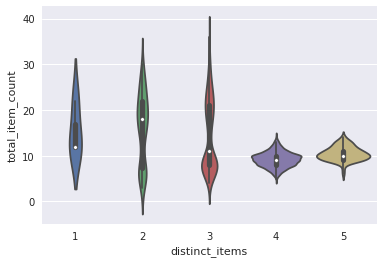

In [8]:
sns.violinplot(x='distinct_items', y='total_item_count', data=user_items_df)

### Guild Membership
The table below shows the guild membership distribution for the 1000 users where None indicates that the user at one point joined and left a guild. Users not present in this data never joined a guild (284 users).

In [9]:
guilds_df = spark.read.parquet('/tmp/guilds')
guilds_df.registerTempTable('guilds')

In [10]:
def map_guild(event):
    return {event.guild_name: 1 if event.action=='join' else -1}
    
def reduce_guild_membership(i1, i2):
    for item, quantity in i1.items():
        i2[item] = i2.get(item, 0) + quantity
    return i2

def current_guild(guild_dict):
    guilds = [guild for guild, v in guild_dict.items() if v==1]
    return guilds[0] if guilds else None

guilds = guilds_df.rdd \
    .filter(lambda x: x.status.startswith('Success')) \
    .map(lambda x: (x.username, map_guild(x))) \
    .reduceByKey(reduce_guild_membership) \
    .map(lambda x: (x[0], current_guild(x[1]))) \
    .toDF(['user', 'guild'])

In [12]:
user_guilds = guilds.toPandas()
user_guilds.groupby(user_guilds.guild.astype(str))[['user']].count()

,user
guild,
None,127
the_brave,302
the_honorable,287


### Item Distribution By Guild
Using the spark sql dataframes:
1. join the item summaries with the guild memberships.
2. group by the guilds.
3. calculate mean and stddevs on the item summaries for the users in each guild.

The users who join guild `the_brave` on average have significantly higher quantity of items compared to other users. Specifically, members of `the_brave` have more than double the quantity of items of those who are members of `the_honorable` (18.9 vs 9.1). However, these users in `the_brave` also tend to have fewer distinct items.

In [13]:
items_and_guilds = items_and_counts.join(guilds, "user", 'left')

In [14]:
guild_stats = items_and_guilds.groupBy('guild') \
    .agg(_mean(col('total_item_count')).alias('mean_item_count'),
         _stddev(col('total_item_count')).alias('std_item_count'),
         _mean(col('distinct_items')).alias('mean_distinct_count'),
         _stddev(col('distinct_items')).alias('std_distinct_count')) \
    .toPandas()

In [15]:
guild_stats

,guild,mean_item_count,std_item_count,mean_distinct_count,std_distinct_count
0,the_brave,18.940397,6.154416,2.870861,0.672091
1,None,10.554745,5.230193,3.586375,0.814029
2,the_honorable,9.111498,2.800120,3.571429,0.734480
